# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [19]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. I represent a position as a 2-tuple of the form `(row, col)`. 

In [20]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


<Figure size 432x288 with 0 Axes>

A helper function to visualize the maze is also available.

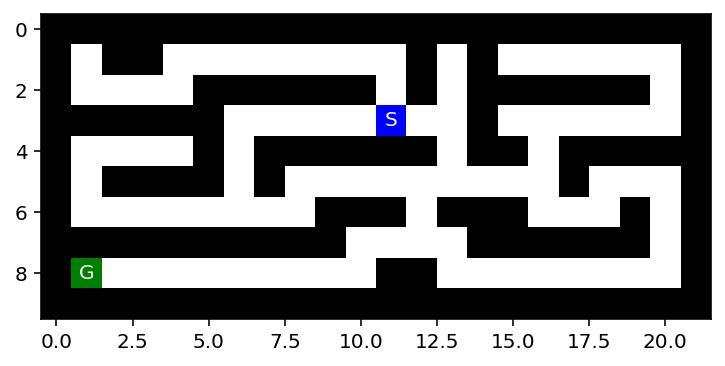

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [22]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [23]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class.


__Tree and memory management example:__ Create the root node and append the node for going east with a cost of 1.

In [24]:
# import sys to access reference counts
import sys

print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))
# Note: -1 is used because passing root to getrefcount adds one reference
print("Root is now referenced twice. Reference count for garbage collection (root node):", sys.getrefcount(root)-1)

print()
print("Note that the root node is safe from garbage collection as long as we have also a reference in node2") 
root = None
print(root)
print("parent of node2 (reference to root node): ", repr(node2.parent))
print("Reference count for garbage collection (root node):", sys.getrefcount(node2.parent)-1)

print()
print("Path from root to node2")
path = node2.get_path_from_root()
print("References:", path)
print("Positions:", [n.pos for n in path])
print("Actions:", [n.action for n in path])
print("Cost:", [n.cost for n in path])


print()
print("Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is exposed to garbage collection.")
node2 = None

Create root node
root: Node - pos = (0, 0); action = None; cost = 0
root (reference): <__main__.Node object at 0x7fccc4b430d0>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); action = E; cost = 1
parent of node2:  Node - pos = (0, 0); action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x7fccc4b430d0>
Root is now referenced twice. Reference count for garbage collection (root node): 2

Note that the root node is safe from garbage collection as long as we have also a reference in node2
None
parent of node2 (reference to root node):  <__main__.Node object at 0x7fccc4b430d0>
Reference count for garbage collection (root node): 1

Path from root to node2
References: [<__main__.Node object at 0x7fccc4b430d0>, <__main__.Node object at 0x7fccc2a0cb50>]
Positions: [(0, 0), (0, 1)]
Actions: [None, 'E']
Cost: [0, 1]

Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is exposed to garbage colle

# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth
* Maximum size of the frontier

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search problem and determining the problem size [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

#### Initial state
The agent start out at the given starting position, labled "S" in the file, which can be described as a 2 dimensional coordinate (x, y). The initial state is on an outer edge of the maze
#### Actions
The agent can choose from four possible movement options: {north, east, south, west}, corresponding to moving in the positive and negative directions on the x and y axes. In code, these actions will be represented by a string containing the first character of the direction.
#### Transition model
A state described in (x, y) coordinates transitions to a new state according to the following function $f$(position, direction):
* $f$((x,y), N) = (x, y - 1)
* $f$((x,y), E) = (x + 1, y)
* $f$((x,y), S) = (x, y + 1)
* $f$((x,y), W) = (x - 1, y)
#### Goal state
The goal state is the (x, y) coordinates of the position in the maze file labeled "G." The goal state is on an outer edge of the maze
#### Path cost
The path cost is measured as the discrete number of steps (number of squares) taken to get from the initial state to the goal state. The agent is not allowed to move diagonally.


Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values from a given maze.

#### n
The state space size is equal to the total number of squares that the agent can occupy. This is calculated by subtracting the number of wall squares from the total area of the rectangular maze: $S=lw - x$, where l = length, w = width, and x = number of wall squares

#### d

#### m

#### b
The branching factor is equal to the number of possible actions, because it represents the number of states that can be reached from a single state. With 4 possible directions to travel in, the maximum branching factor of the tree is <br> $b=4$

## Task 2: Uninformed search: Breadth-first and depth-first [4 points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

#### Helper function - expand

None,E,E,S,S,W,S,S,W,W,S,W,W,W,W,W,W,W,W,W,

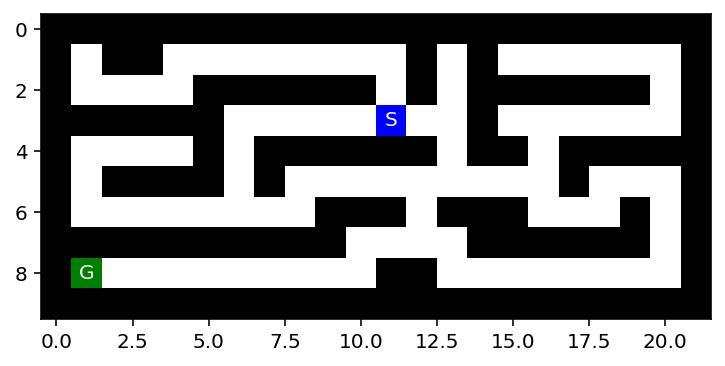

In [41]:
def expand(node, maze):
    """Returns the reachable children of the given node
    Used in all search functions"""

    x = node.pos[0]
    y = node.pos[1]
    children = list()

    for i in [(0, 1, "E"), (0, -1, "W"), (1, 0, "S"), (-1, 0, "N")]: #list of tuples represents how to add to get to a new position in the given direction
        newPos = (x + i[0], y + i[1])
        if look(maze, newPos) != "X":
            children.append(Node(newPos, node, i[2], 0))
    
    return children





#### BFS implementation

In [ ]:
from queue import Queue

def bfs(maze):
    #Initialize root node at starting position of maze and get goal node
    rootPos = find_pos(maze, what="S")
    root = Node(rootPos, None, None, 0)
    goalPos = find_pos(maze, what="G")

    frontier = Queue()
    frontier.put(root)
    reached = list()
    reached.append(root.pos)

    while not frontier.empty():
        node = frontier.get()
        for n in expand(node, maze):
            if n.pos == goalPos:
                return n
            if n.pos not in reached:
                reached.append(n.pos)
                frontier.put(n)
    
    return None




for x in bfs(maze).get_path_from_root():
    print(x.action, end=",")
show_maze(maze)

#### DFS implementation

None,E,E,S,S,W,S,S,W,W,S,W,W,W,W,W,W,W,W,W,

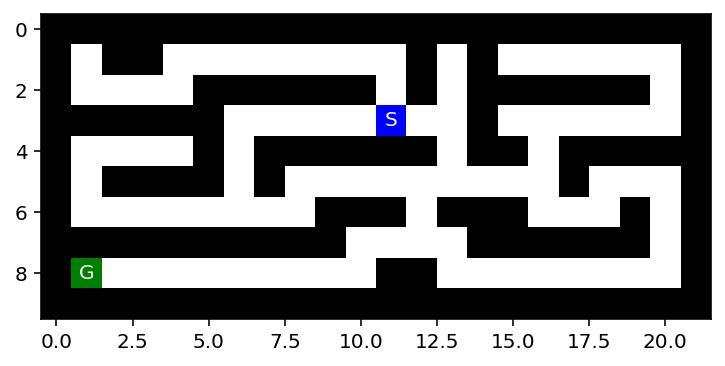

In [46]:
from queue import LifoQueue

def dfs(maze):
    #Initialize root node at starting position of maze and get goal node
    rootPos = find_pos(maze, what="S")
    root = Node(rootPos, None, None, 0)
    goalPos = find_pos(maze, what="G")

    frontier = LifoQueue()
    frontier.put(root)

    while not frontier.empty():
        node = frontier.get()
        for n in expand(node, maze):
            if n.pos == goalPos:
                return n
            if n.pos not in [x.pos for x in frontier]: #check the frontier to prevent cycles within memory
                frontier.put(n)
    
    return None #failure

for x in bfs(maze).get_path_from_root():
    print(x.action, end=",")
show_maze(maze)

How does BFS and DFS deal with loops (cycles)?

In [26]:
# Discussion

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [27]:
# Discussion

## Task 3: Informed search: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

In [28]:
# Your code goes here

Are your implementations complete and optimal? What is the time and space complexity?

In [29]:
# Discussion

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts. 

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [30]:
# Add code, table, charts.

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | nodes expanded | max tree depth | max tree size | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [31]:
# Add discussion

## Graduate student advanced task: Multiple goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement in addition IDS (iterative deepening search using DFS). 

Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [32]:
# Your code/answer goes here

## More advanced tasks to think about

Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [33]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [34]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [35]:
# Your code/answer goes here